In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\Jesper\Documents\GitHub Local\ARFusion


### Functions

In [2]:
def get_average_and_std_df(results_dict):
    losses = results_dict['losses']
    accs = results_dict['accs']
    iso_accs = results_dict['iso_accs']
    sensitivities = results_dict['sensitivities']
    specificities = results_dict['specificities']
    f1_scores = results_dict['F1_scores']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    return df_CV


def get_ab_stats_df(results_dict):
    ab_stats_list = results_dict['ab_stats']
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    num_tot = np.array([ab_stats['num_tot'].tolist() for ab_stats in ab_stats_list])
    avg_num = np.mean(num_tot, axis=0).astype(int).tolist()
    std_num = np.std(num_tot, axis=0).tolist()
    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({
        "avg_num": avg_num, "std_num":std_num,
        "S_share_median": s_share_median, "R_share_median": r_share_median,
        "S_share_std":s_share_std, "R_share_std": r_share_std
    })
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        # if np.isnan(arr).any():
        #     print("metric:", metric)
        #     print(arr)
        #     print("avg:", avg)
        #     print("std:", std)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    return df_ab_CV

### TEMPORARY FIX - make sure no GPU tensors are saved in the results
import pickle, io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


# Compare effect of pre-training difficulty and masking method

## PT: Random masking | FT: Random masking

In [3]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [4]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
F1                0.874695  0.875465  0.878521  0.879817  0.009961  0.007237   
Isolate accuracy  0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
Loss              0.149597  0.149192  0.146501  0.148372  0.008172  0.008240   
Sensitivity       0.836947  0.839979  0.840416  0.843100  0.012828  0.011381   
Specificity       0.978131  0.977496  0.979238  0.979059  0.002428  0.002831   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003893  0.003910  
F1                0.008106  0.007803  
Isolate accuracy  0.003893  0.003910  
Loss              0.009087  0.011312  
Sensitivity       0.010033  0.007992  
Specificity       0.002486  0.002961

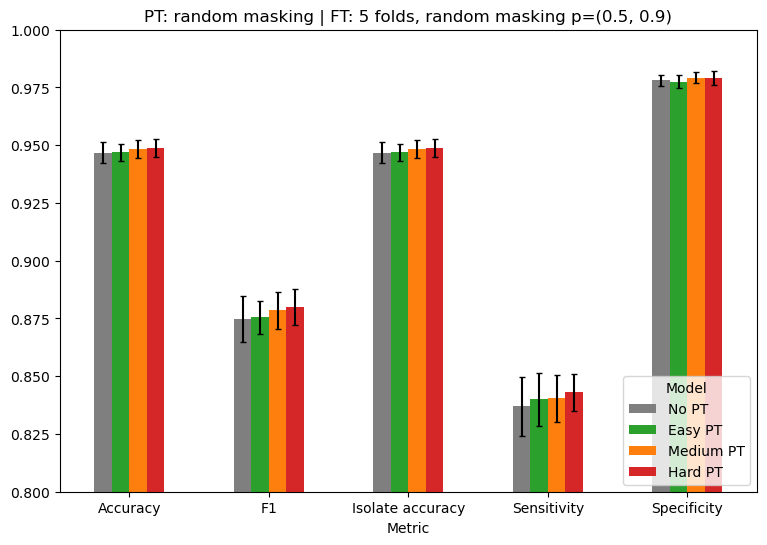

In [5]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, random masking p=(0.5, 0.9)')
plt.show()

### Antibiotic level

## PT: Random masking | FT: Class masking

In [6]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [7]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.947572  0.948383  0.948979  0.949628  0.002161  0.002228   
F1                0.873404  0.874916  0.876475  0.878356  0.004267  0.003956   
Isolate accuracy  0.947572  0.948383  0.948979  0.949628  0.002161  0.002228   
Loss              0.151369  0.148029  0.145753  0.147549  0.008300  0.007169   
Sensitivity       0.836060  0.834348  0.836614  0.840482  0.010292  0.004948   
Specificity       0.978393  0.979842  0.979986  0.979749  0.001231  0.002093   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003364  0.002527  
F1                0.007326  0.004650  
Isolate accuracy  0.003364  0.002527  
Loss              0.009863  0.007940  
Sensitivity       0.007298  0.008009  
Specificity       0.002510  0.001941

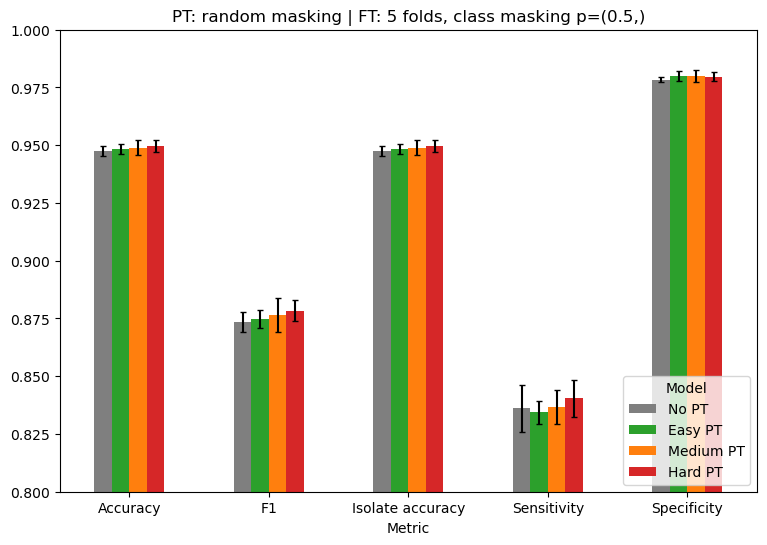

In [8]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, class masking p=(0.5,)')
plt.show()

### Antibiotic level

## PT: Class masking | FT: Random masking

### Compare metrics

In [9]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
# with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    # results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'))
# model_names = ['No CPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
# colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
model_names = ['No PT', 'Easy CPT', 'Medium CPT']
colors = ['tab:gray', 'tab:green', 'tab:orange']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

In [10]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                            std                     
model                No PT  Easy CPT Medium CPT     No PT  Easy CPT Medium CPT
metric                                                                        
Accuracy          0.946814  0.947611   0.946503  0.004637  0.004291   0.005164
F1                0.874695  0.876991   0.873534  0.009961  0.008907   0.011227
Isolate accuracy  0.946814  0.947611   0.946503  0.004637  0.004291   0.005164
Loss              0.149597  0.148138   0.147769  0.008172  0.009704   0.011967
Sensitivity       0.836947  0.841948   0.832904  0.012828  0.013077   0.014379
Specificity       0.978131  0.977746   0.978890  0.002428  0.003376   0.002658

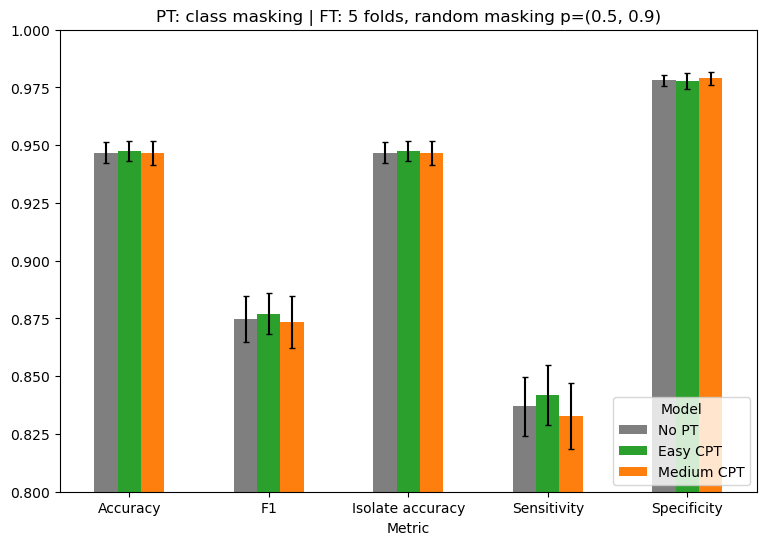

In [11]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, random masking p=(0.5, 0.9)')
plt.show()

### Antibiotic level

## PT: Class masking | FT: Class masking

In [12]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [13]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                      std            \
model                No PT  Easy CPT Medium CPT  Hard CPT     No PT  Easy CPT   
metric                                                                          
Accuracy          0.947572  0.947660   0.948753  0.950298  0.002161  0.002662   
F1                0.873404  0.873679   0.876492  0.879477  0.004267  0.004697   
Isolate accuracy  0.947572  0.947660   0.948753  0.950298  0.002161  0.002662   
Loss              0.151369  0.148669   0.147631  0.146856  0.008300  0.008238   
Sensitivity       0.836060  0.836449   0.840490  0.838171  0.010292  0.009150   
Specificity       0.978393  0.978360   0.978635  0.981268  0.001231  0.003971   

                                       
model            Medium CPT  Hard CPT  
metric                                 
Accuracy           0.002788  0.002883  
F1                 0.005696  0.005968  
Isolate accuracy   0.002788  0.002883  
Loss               0.008179  0.006702  
Sensitivity        0.008301  0.011392  
Specificity        0.001701  0.002151

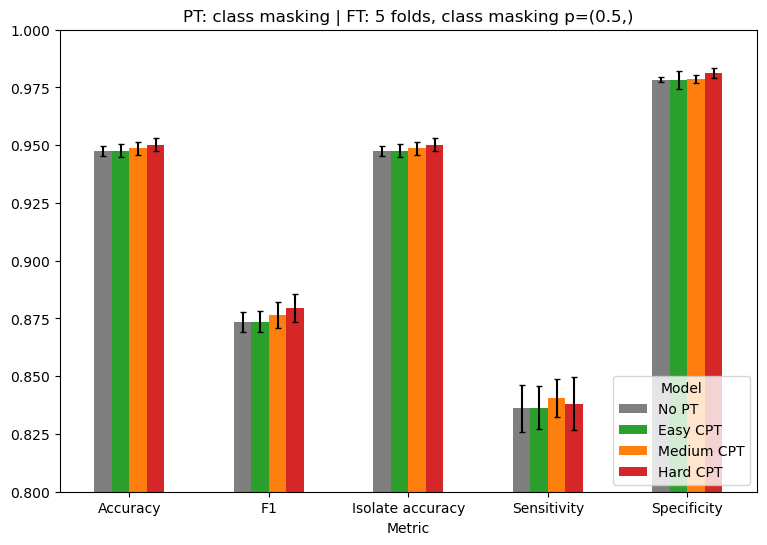

In [14]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, class masking p=(0.5,)')
plt.show()

### Antibiotic level

## Analysis

In [15]:
df_ab_CV_noPT = get_ab_stats_df(results_dict_noPT)
df_ab_CV_noPT

,antibiotic,avg_num,std_num,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
0,AMP,1061,29.346209,0.528855,0.471145,0.005463,0.005463,0.889118,0.006291,0.819142,0.015646,0.950993,0.003040,0.936688,0.003104,0.873886,0.008480
1,CAZ,730,14.998667,0.731544,0.268456,0.012136,0.012136,0.934324,0.004278,0.863931,0.019982,0.961127,0.003601,0.893602,0.010080,0.878283,0.007414
2,CIP,1283,16.475436,0.808251,0.191749,0.005569,0.005569,0.955571,0.002974,0.847031,0.015630,0.981146,0.004119,0.913750,0.018107,0.878900,0.008936
3,CRO,1155,6.693280,0.809896,0.190104,0.009187,0.009187,0.965191,0.003006,0.895135,0.011822,0.982033,0.003702,0.921882,0.018038,0.908145,0.008696
4,CTX,160,8.867920,0.125000,0.875000,0.017282,0.017282,0.964583,0.017499,0.991623,0.006739,0.782378,0.106256,0.968557,0.014683,0.979916,0.009804
5,FEP,741,12.846789,0.815321,0.184679,0.010157,0.010157,0.931939,0.008255,0.778656,0.036119,0.966654,0.003893,0.839499,0.020720,0.807467,0.022609
6,GEN,1167,22.249494,0.874891,0.125109,0.007369,0.007369,0.946700,0.002280,0.677724,0.010419,0.985133,0.000938,0.866263,0.013985,0.760387,0.008471
7,IPM,511,10.770330,0.982353,0.017647,0.005036,0.005036,0.990620,0.004107,0.533838,0.100676,0.998810,0.001593,0.902857,0.122024,0.665702,0.102188
8,LVX,585,13.496666,0.695876,0.304124,0.005393,0.005393,0.955212,0.005483,0.914506,0.015014,0.973057,0.002990,0.936755,0.008017,0.925437,0.009641
9,MFX,11,1.496663,0.307692,0.692308,0.122032,0.122032,0.736014,0.156110,0.788889,0.123728,0.644762,0.279481,0.796111,0.146835,0.784670,0.119418


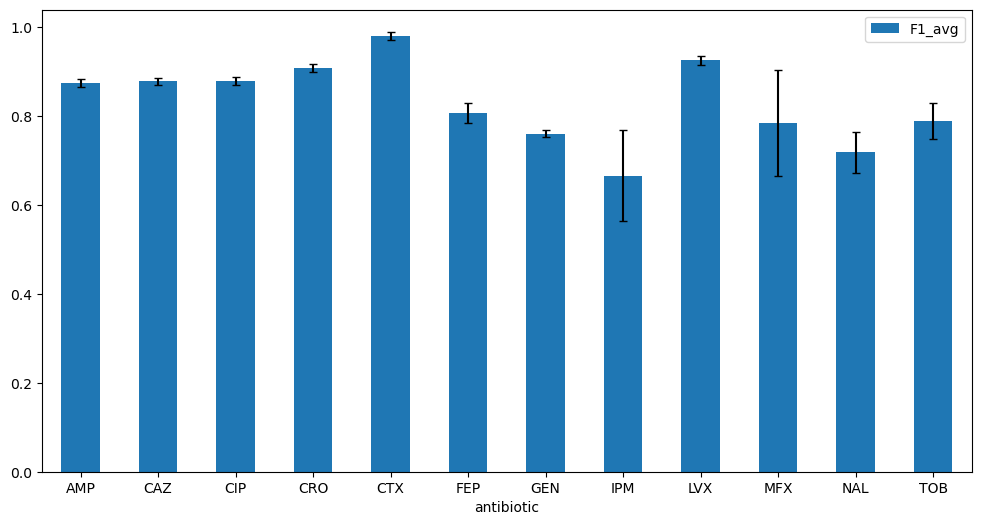

In [16]:
df_ab_CV_noPT.plot(x="antibiotic", y="F1_avg", yerr="F1_std", kind="bar", figsize=(12, 6), capsize=3, rot=0)
plt.show()

In [17]:
df_ab_CV_mediumPT = get_ab_stats_df(results_dict_mediumPT)
df_ab_CV_mediumPT

,antibiotic,avg_num,std_num,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
0,AMP,1061,29.346209,0.528855,0.471145,0.005463,0.005463,0.890054,0.005977,0.820469,0.012939,0.951593,0.005670,0.937592,0.006154,0.875053,0.007169
1,CAZ,730,14.998667,0.731544,0.268456,0.012136,0.012136,0.933750,0.006827,0.878941,0.029709,0.954418,0.011863,0.881176,0.022553,0.879365,0.009679
2,CIP,1283,16.475436,0.808251,0.191749,0.005569,0.005569,0.957303,0.001052,0.842809,0.017024,0.984384,0.004620,0.927234,0.020756,0.882612,0.001802
3,CRO,1155,6.693280,0.809896,0.190104,0.009187,0.009187,0.966567,0.003809,0.896590,0.007302,0.983245,0.004314,0.927916,0.016345,0.911879,0.007566
4,CTX,160,8.867920,0.125000,0.875000,0.017282,0.017282,0.962103,0.018097,0.988452,0.008831,0.787586,0.130267,0.968808,0.017426,0.978442,0.010269
5,FEP,741,12.846789,0.815321,0.184679,0.010157,0.010157,0.931935,0.010296,0.787237,0.040992,0.964641,0.004370,0.833065,0.022363,0.809127,0.029124
6,GEN,1167,22.249494,0.874891,0.125109,0.007369,0.007369,0.949107,0.003826,0.689201,0.060342,0.985905,0.004060,0.877234,0.022699,0.769719,0.033407
7,IPM,511,10.770330,0.982353,0.017647,0.005036,0.005036,0.991021,0.004618,0.609091,0.071966,0.997620,0.002872,0.869206,0.146437,0.710000,0.081822
8,LVX,585,13.496666,0.695876,0.304124,0.005393,0.005393,0.959061,0.001826,0.919217,0.005133,0.976476,0.002103,0.944642,0.005743,0.931743,0.004187
9,MFX,11,1.496663,0.307692,0.692308,0.122032,0.122032,0.794794,0.088012,0.888889,0.060858,0.584762,0.160876,0.804444,0.095041,0.842389,0.073383


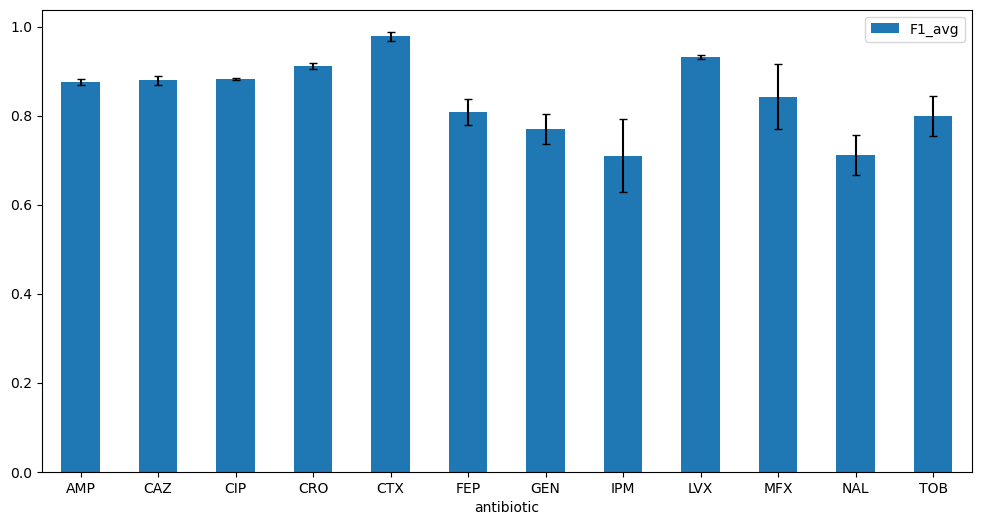

In [18]:
df_ab_CV_mediumPT.plot(x="antibiotic", y="F1_avg", yerr="F1_std", kind="bar", figsize=(12, 6), capsize=3, rot=0)
plt.show()